In [63]:
import numpy as np
import cv2
import kagglehub
import json
import os
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

path = kagglehub.dataset_download("humansintheloop/teeth-segmentation-on-dental-x-ray-images")

print("Path to dataset files:", path)

Path to dataset files: /home/mamusiaarusia/.cache/kagglehub/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images/versions/1


In [ ]:
sources = {k: Path(path) / f'Teeth Segmentation {k}' for k in ['JSON', 'PNG']}

meta = {}
for p in sources.values():
    meta.update(json.loads((p / 'meta.json').read_text()))

images = [
    Image.open(img_path) 
    for p in sources.values() 
    for img_path in (p / 'd2' / 'img').glob('*')
]

images_np = [np.array(image) for image in images]

# kszalt zdjec: 1024 x (1024 - 2041) w zaleznosci od zdjecia

In [432]:
def to_fft(img):
    # cv2 musi miec float32 na wejsciu
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    return np.fft.fftshift(dft) # 0hz (srednia) na srodek

def from_fft(dft_shifted):
    f_ishift = np.fft.ifftshift(dft_shifted) # 0hz z powrotem do rogu
    img_back = cv2.idft(f_ishift) # odwrotna transformata
    mag = cv2.magnitude(img_back[:,:,0], img_back[:,:,1]) # amplituda (modul zespolonej)
    cv2.normalize(mag, mag, 0, 255, cv2.NORM_MINMAX) # zeby nie wywalilo wartosci w kosmos
    return np.uint8(mag)

def get_bandpass_mask(image, r_min, r_max):
    rows, cols, _ = image.shape
    crow, ccol = rows // 2, cols // 2
    
    y, x = np.ogrid[:rows, :cols]
    dist = np.sqrt((x - ccol)**2 + (y - crow)**2) # pitagoras od srodka
    
    mask = np.zeros((rows, cols, 2), np.float32) # 2 kanaly bo liczby zespolone
    mask[(dist >= r_min) & (dist <= r_max)] = 1 # przepuszczamy pasmo
    return image * mask\
    
def apply_gaussian_hpf(fft_img, d0):
    h, w = fft_img.shape[:2]
    cy, cx = h // 2, w // 2
    
    y, x = np.ogrid[:h, :w]
    dist_sq = (x - cx)**2 + (y - cy)**2 # kwadrat odleglosci (optymalizacja)
    
    mask = 1 - np.exp(-dist_sq / (2 * d0**2)) # Wzor Gaussa HPF
    
    mask = np.dstack([mask, mask]) # klonujemy na 2 kanaly (Re+Im)
    return fft_img * mask

def apply_butterworth_hpf(fft_img, d0, n):
    h, w = fft_img.shape[:2]
    cy, cx = h // 2, w // 2
    
    y, x = np.ogrid[:h, :w]
    dist = np.sqrt((x - cx)**2 + (y - cy)**2) # odleglosc od srodka
    
    # Wzor Butterwortha HPF. Epsilon 1e-5 zeby nie dzielic przez 0
    # n=1 (miekkie), n=5 (ostre), d0=promien odciecia
    mask = 1 / (1 + (d0 / (dist + 1e-5))**(2 * n))
    
    mask = np.dstack([mask, mask]) # 2 kanaly dla fft
    return fft_img * mask

def thresholding(image: np.ndarray[int], /, n: int = None, custom_thresholds: np.ndarray = None) -> np.ndarray:
    if n is not None:
        thresholds = np.linspace(0, 255, num=n)
    elif custom_thresholds is not None:
        thresholds = custom_thresholds
    else:
        raise ValueError("Either n or custom_thresholds must be provided")

    for i in range(1, len(thresholds)):
        avg = (thresholds[i] + thresholds[i-1]) // 2
        image[(image < thresholds[i]) & (image > thresholds[i-1])] = avg

    return image

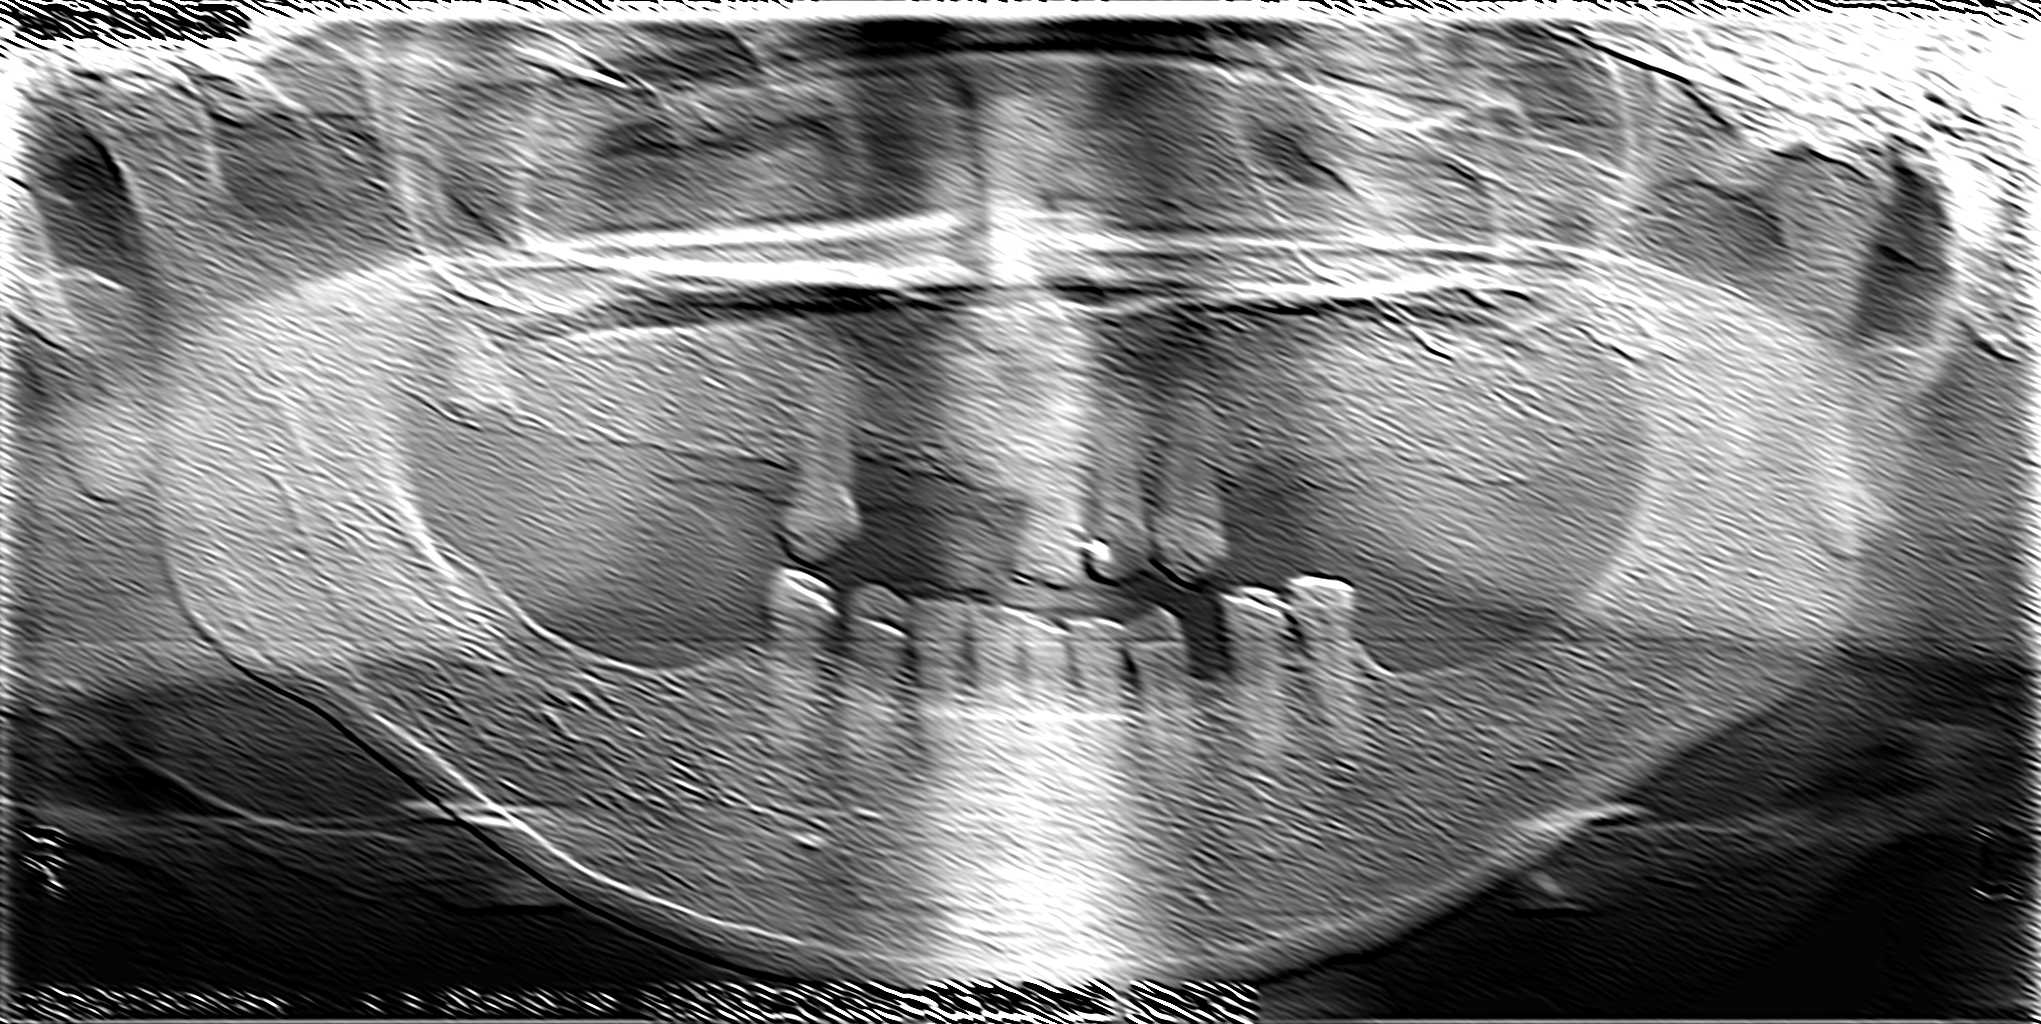

In [430]:
# dobrze byloby wyfiltrowac niepionowe rzeczy gaborem
# tj. Sa zeby lezacy w zbiorze danych, ale nimi ja sie nie przejmuje

image = images_np[0]

kernel_size = (50, 50)
sigma = 3
theta = 90
lambda_val = 7 # dlugosc fali
gamma = 0.5 # aspect ratio - 0 = kreska, 0.5 = jakas elipsa, 1.0 - okrag
psi = np.pi/3 # offset fazy - 0 = wykrywanie linii, pi/2 = Krawedzie, pi = Wykrywanie ciemnych linii na jasnym tle

# Gabor na pewno sie przyda
kernel = cv2.getGaborKernel(kernel_size, sigma, theta, lambda_val, gamma, psi, ktype=cv2.CV_32F)

# 2. Splot (Convolve)
# Przesuwa kernel po obrazie i mnozy. filter2D robi to mega szybko.
filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)

Image.fromarray(filtered)

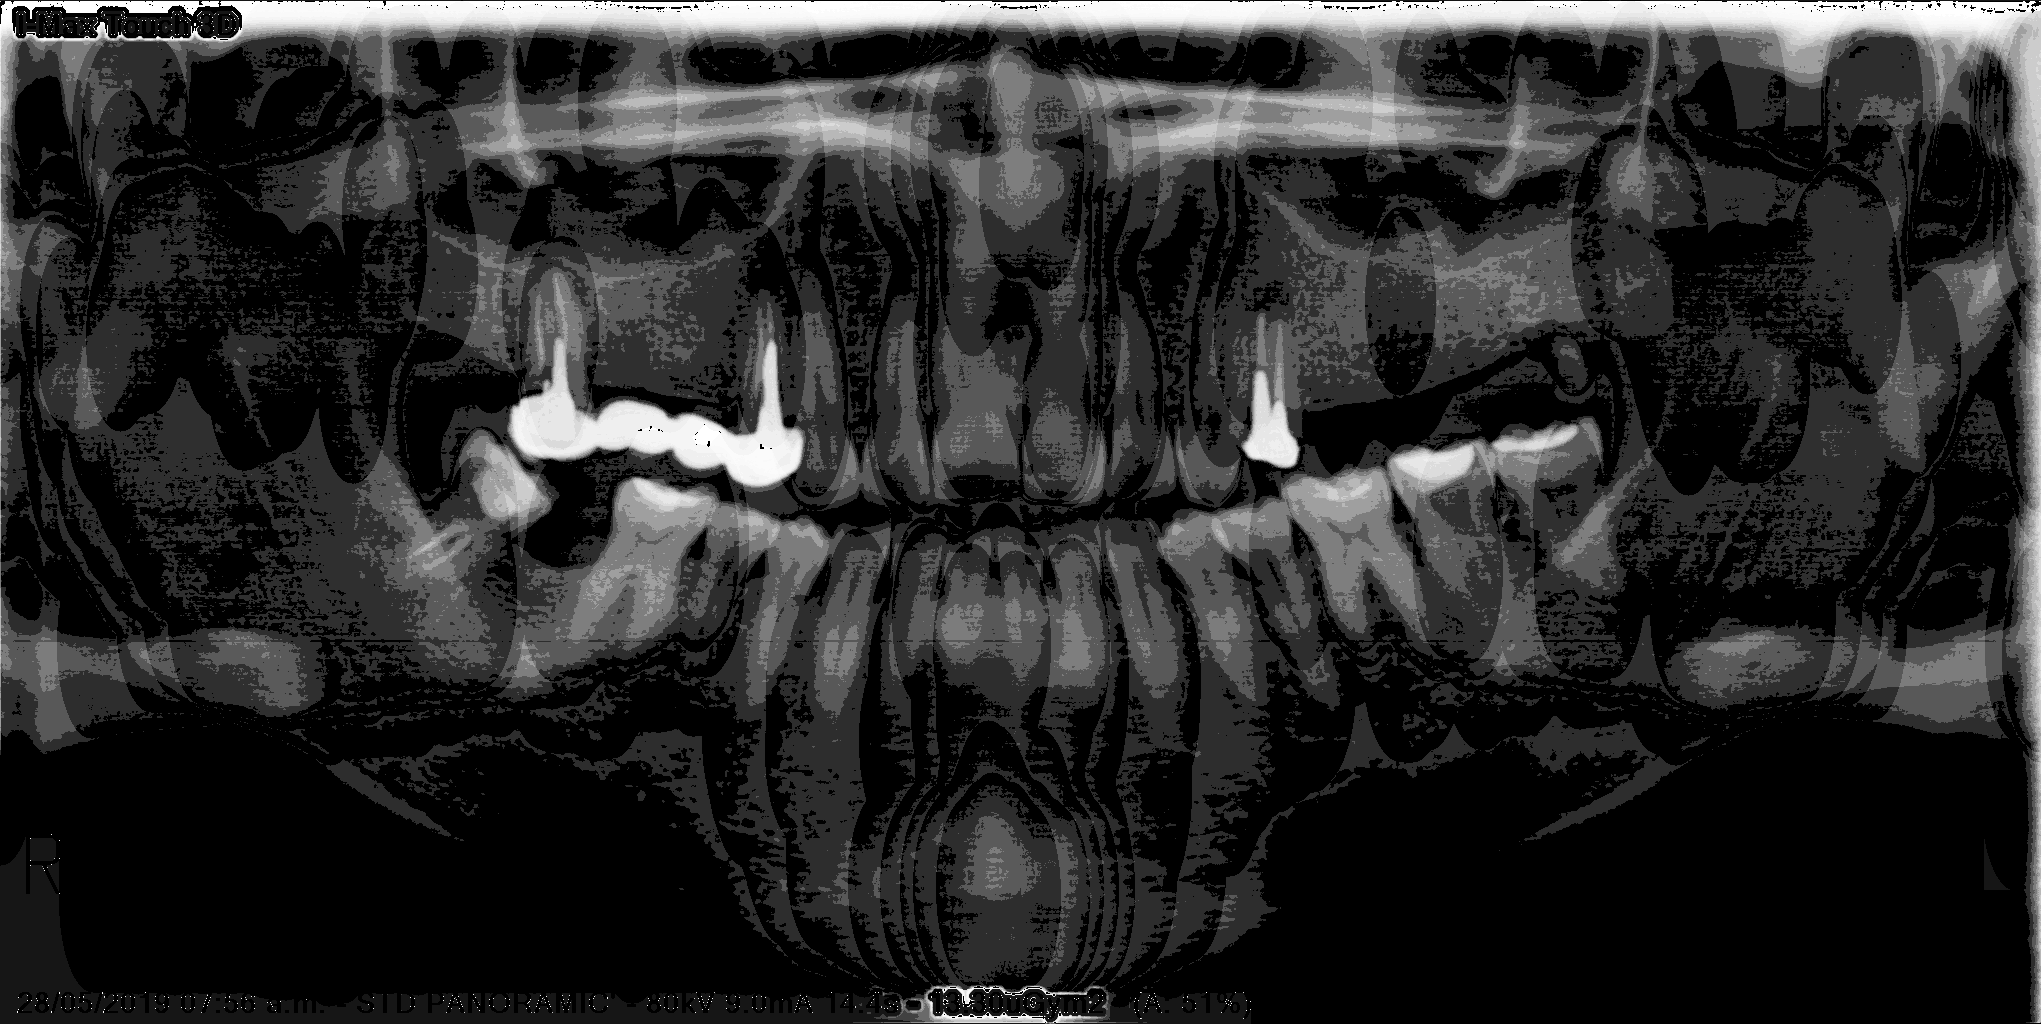

In [600]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (69, 185))

#* PLAYGROUND 
#! tutaj trzeba wywalic ta szczeke i taki jest caly cel - wywalic to na gorze napompowac balonikiem i wywalic
image = images_np[101]
image[image >= 250] = 0.0 # usuwanie super jasnych napisow 
image = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)

# moze gauss dolno-przepustowy by tu wszedl
# fourier_image = to_fft(image)
# filtered_fourier = apply_gaussian_hpf(fourier_image, 2)
# image = from_fft(filtered_fourier)

gain = 5
cutoff = 0

image -= cutoff
image = image.astype(float) / 255.0

image = 1 / (1 + np.exp(-gain * image))
image = np.uint8(np.round(image * 255))

image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

# image = thresholding(image, n=7)

Image.fromarray(image)

(array([723636., 834318., 364016.,  41474.,  27604.,  20191.,  15157.,
         10637.,  16683.,  36268.]),
 array([128. , 140.5, 153. , 165.5, 178. , 190.5, 203. , 215.5, 228. ,
        240.5, 253. ]),
 <BarContainer object of 10 artists>)

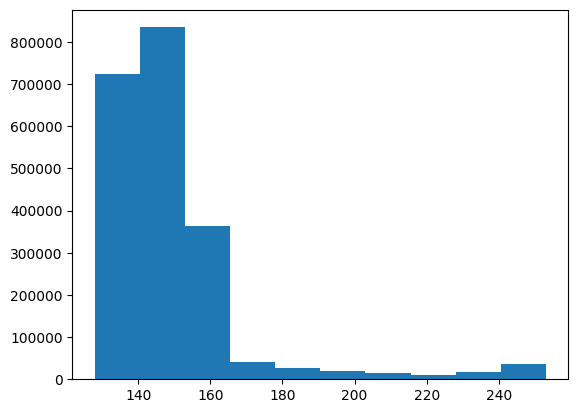

In [528]:
plt.hist(image.flatten())

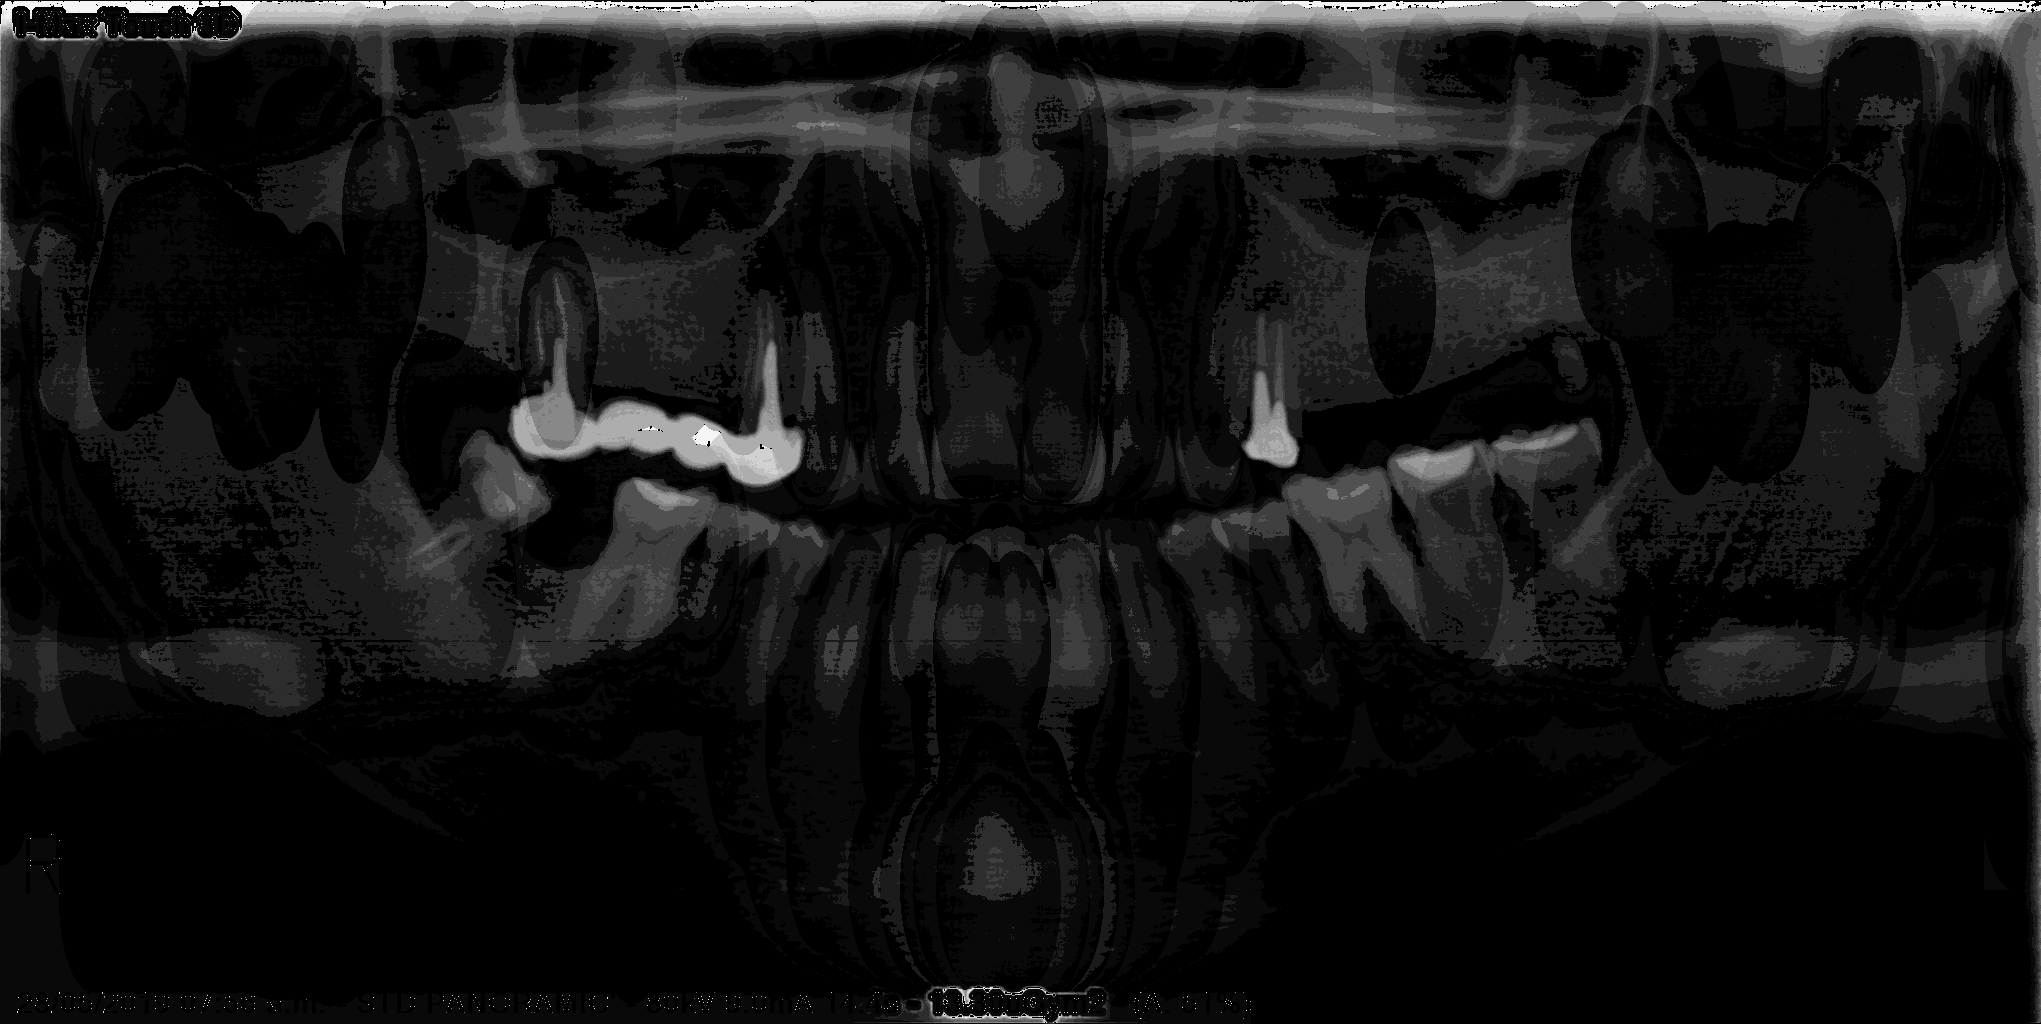

In [573]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (69, 185))

#* PLAYGROUND 
#! tutaj trzeba wywalic ta szczeke i taki jest caly cel
image = images_np[101]
image[image >= 250] = 0.0 # usuwanie super jasnych napisow 
image = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)

# moze gauss dolno-przepustowy by tu wszedl
# fourier_image = to_fft(image)
# filtered_fourier = apply_gaussian_hpf(fourier_image, 0.1)
# image = from_fft(filtered_fourier)

image = thresholding(image, n=15)

Image.fromarray(image)

(array([1018949.,  595162.,  260342.,   96178.,   40164.,   28066.,
          19264.,   13632.,    8411.,    9816.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

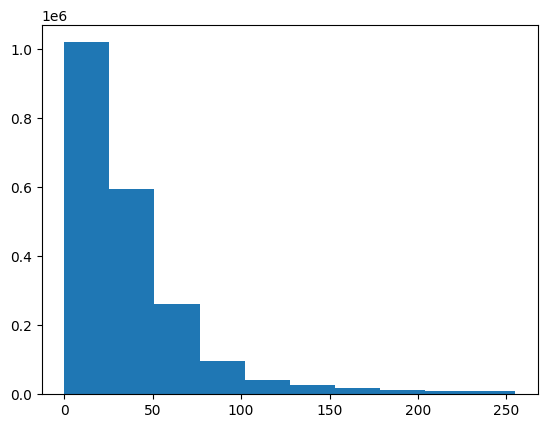

In [442]:
image = image.flatten()
plt.hist(image)

In [ ]:
"""
    Transformata Fouriera to nie jest dobry pomysl - wydaje sie jakby pasowal do problemu ale tak naprawde
    Wypadaloby sprawdzic detekcje linii - brzmi to dosyc dobrze
    
"""

'\n    Transformata Fouriera to nie jest dobry pomysl - wydaje sie jakby pasowal do problemu ale tak naprawde\n'